# <center style="font-family:Arial, font-size:Bold">1. Feature Engineering</center>
<a class="anchor" id="4"></a> 
## 1.1 `RestingBP`

The patient's blood pressure is represented by restingBP. Due to the fact that it is impossible to have values equal to 0, I will do median imputation to the outliers.

In [425]:
def detect_outliers(df,features):
    df_copy = df.drop(df[(df[features] == 0)].index)
    # 1st quartile
    q1 = df_copy[features].quantile(0.25)
    # 3rd quartile
    q3 = df_copy[features].quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    outlier_list_col = df_copy[(df_copy[features] >= Upper_tail) | (df_copy[features] <= Lower_tail)]  # | means "or"
    return pd.DataFrame(outlier_list_col)

In [426]:
RestingBP_outlier = detect_outliers(df,'RestingBP')
RestingBP_outlier.value_counts(RestingBP_outlier['HeartDisease'])

HeartDisease
1    28
0    13
dtype: int64

In [427]:
Cholesterol_outlier = detect_outliers(df,'Cholesterol')
Cholesterol_outlier.value_counts(Cholesterol_outlier['HeartDisease'])

HeartDisease
1    13
0    10
dtype: int64

In [428]:
imputer = SimpleImputer(strategy='median')

# We fit the imputer to the train set.
# The imputer will learn the median of all variables.
cols_to_use = ['Cholesterol','RestingBP']
imputer.fit(df[cols_to_use])

SimpleImputer(strategy='median')

In [429]:
df[cols_to_use] = imputer.transform(df[cols_to_use])

In [430]:
df.ChestPainType.value_counts()

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

##  1.2 Missing Values

In [431]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

We don't have any missing values! That is great!

## 1.3 `Age`

Let's divide the ages into age groups!

In [432]:
df['AgeGroup']= np.nan
df.loc[(df['Age']>=28) & (df['Age']<35),'AgeGroup']='Young Adult' 
df.loc[(df['Age']>=35) & (df['Age']<=64),'AgeGroup']='Adult'
df.loc[df['Age']>64,'AgeGroup']='Seniors'

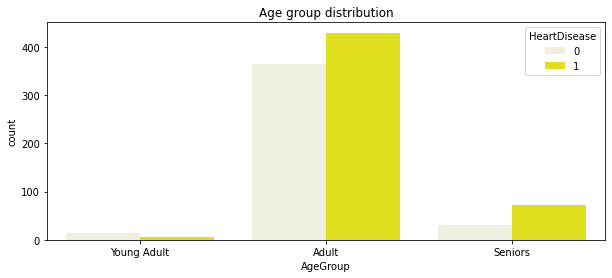

In [433]:
plt.figure(figsize=(10,4))
g=sns.countplot(data=df, x='AgeGroup', hue='HeartDisease', order=['Young Adult','Adult','Seniors'],color='yellow')
plt.title('Age group distribution')
plt.show()

In [434]:
df.drop(['Age'], axis=1, inplace=True)

## 1.4 Encoding

In [435]:
catcols = ['Sex', 'ChestPainType','FastingBS','RestingECG',
            'ExerciseAngina',  'ST_Slope','AgeGroup']

In [436]:
def Label_Encoding(df,feature):
    label_encoder = LabelEncoder()
    df[feature]= label_encoder.fit_transform(df[feature])

In [437]:
for i in catcols:
    Label_Encoding(df,i)

In [438]:
df.head()

,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,AgeGroup
0,1,1,140.0,289.0,0,1,172,0,0.0,2,0,0
1,0,2,160.0,180.0,0,1,156,0,1.0,1,1,0
2,1,1,130.0,283.0,0,2,98,0,0.0,2,0,0
3,0,0,138.0,214.0,0,1,108,1,1.5,1,1,0
4,1,2,150.0,195.0,0,1,122,0,0.0,2,0,0


## 1.5 Scaling

In [439]:
numcols  = ['RestingBP','Cholesterol','MaxHR']

In [440]:
scaler = StandardScaler()

# Scale data
df[numcols] = scaler.fit_transform(df[numcols])

In [441]:
df.head()

,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,AgeGroup
0,1,1,0.410909,0.825070,0,1,1.382928,0,0.0,2,0,0
1,0,2,1.491752,-0.171961,0,1,0.754157,0,1.0,1,1,0
2,1,1,-0.129513,0.770188,0,2,-1.525138,0,0.0,2,0,0
3,0,0,0.302825,0.139040,0,1,-1.132156,1,1.5,1,1,0
4,1,2,0.951331,-0.034755,0,1,-0.581981,0,0.0,2,0,0


## 1.6 Train test split

In [442]:
# Set up X and y variables
y, X = df['HeartDisease'], df.drop(columns='HeartDisease')

# Split the data into training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# <center style="font-family:Arial, font-size:Bold">2. Prediction</center>
<a class="anchor" id="5"></a> 

## 2.1 Logistic Regression

In [443]:
logreg = LogisticRegression()

In [444]:
logreg.fit(X_train,y_train)

LogisticRegression()

In [445]:
y_pred = logreg.predict(X_test)

In [446]:
logregAcc = accuracy_score(y_test,y_pred)
logregAcc

0.8659420289855072

<AxesSubplot:>

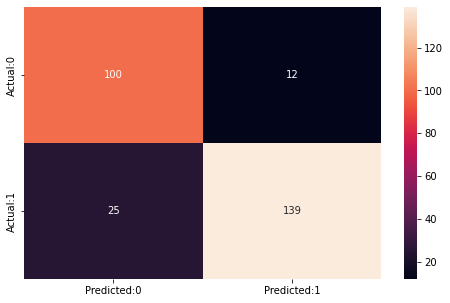

In [447]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d')

## 2.2 K-Nearest Neighbor Classifier

In [448]:
# Building a model using KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 5)

knn.fit(X_train, y_train)

KNeighborsClassifier()

In [449]:
y_pred = knn.predict(X_test)

In [450]:
knnAcc = accuracy_score(y_test,y_pred)
knnAcc

0.8659420289855072

<AxesSubplot:>

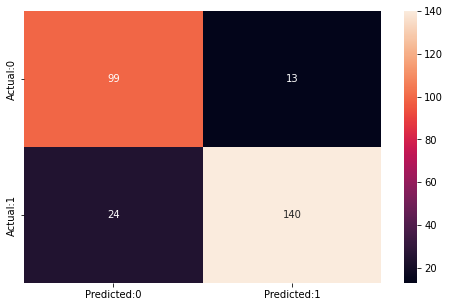

In [451]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d')

## 2.3 Decision Tree Classifier

In [452]:
# Building Decision Tree model 
clf = tree.DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [453]:
y_pred = clf.predict(X_test)

In [454]:
clfAcc = accuracy_score(y_test,y_pred)
clfAcc

0.7717391304347826

<AxesSubplot:>

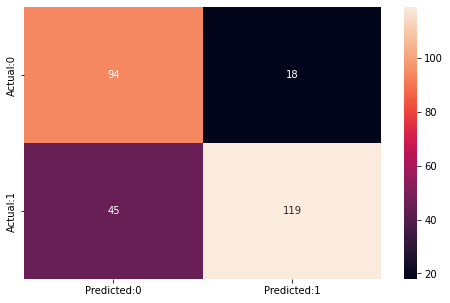

In [455]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d')

## 2.4 Support Vector Machine

In [491]:
svm = SVC(random_state=1)
svm.fit(X_train,y_train)

SVC(random_state=1)

In [492]:
y_pred = svm.predict(X_test)

In [493]:
svmAcc = accuracy_score(y_test,y_pred)
svmAcc

0.8840579710144928

<AxesSubplot:>

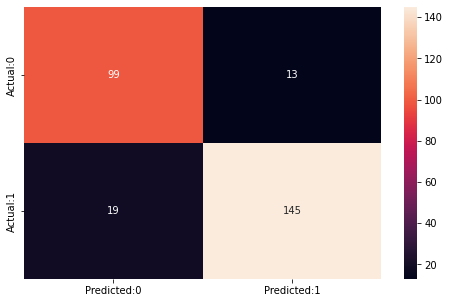

In [460]:
cm = confusion_matrix(y_test,y_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d')

## 2.5 Comparison

In [465]:
data={'Estimators':['Logistic Regression', 'K-Nearest Neighbor', 'Decision Tree','Support Vector Machine'],
      'Accuracy':[logregAcc,knnAcc,clfAcc,svmAcc]}

data =pd.DataFrame(data)

data.sort_values('Accuracy', ascending=False)

,Estimators,Accuracy
3,Support Vector Machine,0.884058
0,Logistic Regression,0.865942
1,K-Nearest Neighbor,0.865942
2,Decision Tree,0.771739


Support vector machine is best among all of the estimators.

## 2.6 Grid Search

In [515]:
# The parameters to be fit
param_grid = {'C': [0.1, 1, 10,50, 100, 1000,1500,2000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['poly','rbf', 'sigmoid','linear']} 

# The grid search object
gridsearch = GridSearchCV(SVC(), 
                      param_grid=param_grid, 
                      cv = 10)

# Do the grid search
gridsearch = gridsearch.fit(X_train, y_train)

In [516]:
print("best param: ", gridsearch.best_params_)

best param:  {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


In [517]:
best_params = gridsearch.best_params_
svm = SVC(random_state=1, **best_params)
                            
svm = svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [518]:
print('Accuracy score: ', accuracy_score(y_test, y_pred))

Accuracy score:  0.8804347826086957


## <center>THANK YOU</center>